In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

pd.set_option('display.width', 1000)

In [2]:
target_symbol = 'NVDA'
symbol_list = ['AAPL', 'MSFT', 'IBM', 'JPM', 'JNJ', '^GSPC', '^IXIC']

In [3]:
ticker = yf.Ticker(target_symbol)
df_target = ticker.history(period='10y')
df_target.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
df_target['Rate'] = df_target['Close'].pct_change()*100
df_target['Rate'][0] = (df_target['Close'][0] - df_target['Open'][0]) / df_target['Open'][0] * 100

c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
def get_symbol_list_data(df_target, symbol_list):
    # start_time = (datetime.date.today() - datetime.timedelta(days=727)).strftime('%Y-%m-%d')
    for symbol in symbol_list:
        ticker = yf.Ticker(symbol)
        symbol_history = ticker.history(period='10y')
        symbol_history.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
        symbol_history[f'Rate_{symbol}'] = symbol_history['Close'].pct_change()*100
        symbol_history[f'Rate_{symbol}'][0] = (symbol_history['Close'][0] - symbol_history['Open'][0]) / symbol_history['Open'][0] * 100
        df_target = pd.concat([df_target, symbol_history[f'Rate_{symbol}']], axis=1)
    return df_target

In [5]:
df_symbol_history = get_symbol_list_data(df_target, symbol_list)

df_symbol_history.reset_index(inplace=True)
df_symbol_history['Date'] = df_symbol_history['Date'].dt.strftime('%Y-%m-%d')
df_symbol_history.set_index(df_symbol_history['Date'], inplace=True)
df_symbol_history.drop(['Date'], axis=1, inplace=True)

c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\ozing\miniconda3\envs\RL_trader\lib\s

In [6]:
df_symbol_history

,Open,High,Low,Close,Volume,Rate,Rate_AAPL,Rate_MSFT,Rate_IBM,Rate_JPM,Rate_JNJ,Rate_^GSPC,Rate_^IXIC
Date,,,,,,,,,,,,,
2013-02-19,2.941899,2.944208,2.881860,2.900333,43355200,-1.412868,-0.240737,0.609756,-0.139580,0.671828,1.223202,0.733648,0.504467
2013-02-20,2.909571,2.955754,2.849532,2.858769,71301200,-1.433101,-2.421755,-0.641714,-0.504199,-1.698662,-0.402786,-1.240414,-1.530381
2013-02-21,2.854150,2.886478,2.831058,2.837986,58040800,-0.726998,-0.621622,-1.363454,-0.491670,-0.740565,0.287014,-0.630306,-1.040318
2013-02-22,2.856460,2.893407,2.840295,2.891098,37014800,1.871469,1.064882,0.982150,1.391596,1.367842,-0.013137,0.877247,0.968551
2013-02-25,2.898024,2.921116,2.835676,2.840295,64444400,-1.757220,-1.776779,-1.404904,-1.780299,-2.473924,-0.891773,-1.830958,-1.441261
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,215.380005,220.479996,209.619995,217.880005,47491900,2.459446,1.880678,3.124287,1.290560,1.084809,0.370039,1.144861,1.482063
2023-02-14,215.779999,230.490005,213.660004,229.710007,67547400,5.429595,-0.422495,0.313292,-0.975618,0.441881,-0.436259,-0.028041,0.574853
2023-02-15,225.490005,228.550003,221.059998,227.639999,42118800,-0.901139,1.390343,-0.799298,0.286743,0.418999,-1.647745,0.277318,0.923395


[]

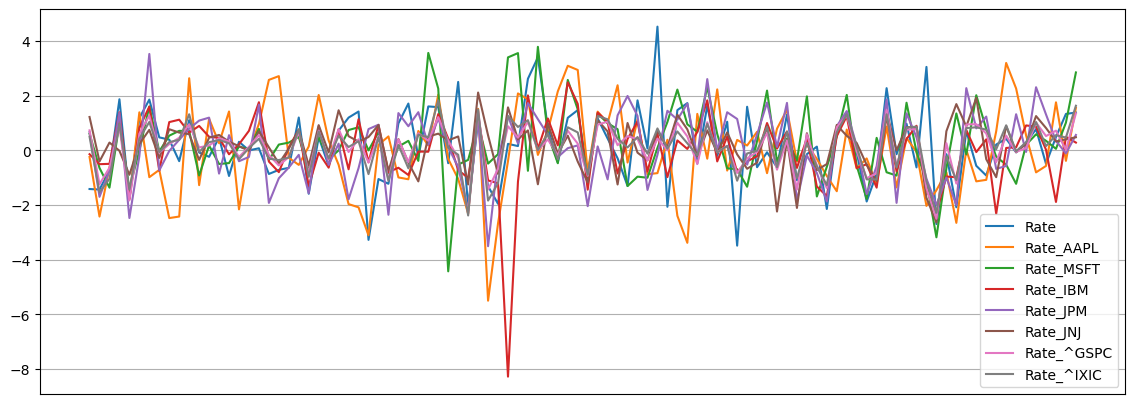

In [7]:
plt.figure(figsize=(14,5))
plt.plot(df_symbol_history.iloc[:, 5:][:100], label=df_symbol_history.columns[5:])
plt.grid()
plt.legend()
plt.gca().axes.xaxis.set_visible(False)
plt.plot()

In [8]:
import darts
from darts.models.forecasting.nbeats import NBEATSModel

num_rows = len(df_symbol_history)
num_columns = len(df_symbol_history.columns)
forecast_length = 5
backcast_length = 4 * forecast_length
target_column = 'Close'

# normal data split
def make_X_y(data):
    X, y = [], []
    for i in range(backcast_length, len(data)-forecast_length+1):
        X.append(data[i-backcast_length:i])
        y.append(data[target_column][i:i+forecast_length])
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    X = np.reshape(X, (-1, len(df_symbol_history.columns), backcast_length))
    X, y = darts.TimeSeries.from_values(X), darts.TimeSeries.from_values(y)
    return X, y

def split_train_val_test(data, percent):
    train_data = data[:int(len(data)*percent[0])]
    val_data = data[int(len(data)*percent[0]):int(len(data)*percent[1])]
    test_data = data[int(len(data)*percent[1]):]
    X_train, y_train = make_X_y(train_data)
    X_val, y_val = make_X_y(val_data)
    X_test, y_test = make_X_y(test_data)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test(df_symbol_history, (0.7, 0.9))

model = NBEATSModel(
    input_chunk_length=backcast_length,
    output_chunk_length=forecast_length,
    generic_architecture=False,
)

In [9]:
model.fit(X_train, epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 685 K 
---------------------------------------------------
546 K     Trainable params
138 K     Non-trainable params
685 K     Total params
2.740     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Number of components is larger than 10 (13). Plotting only the first 10 components.


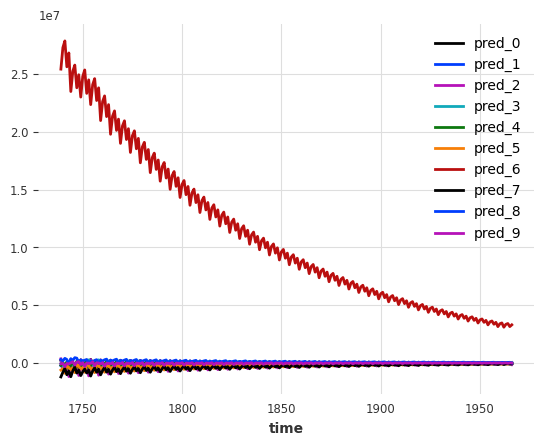

In [14]:
pred = model.predict(len(X_test))
pred.plot(label='pred')